# **Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install**

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 14.2 MB/s eta 0:00:00


# **Imports 📢**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm.notebook import tqdm

from glob import glob

In [3]:
torch.__version__

'2.0.1+cu118'

# **Dataset 🗂️**

## Load dataset

In [4]:
!cp '/content/drive/MyDrive/Dataset/UCI HAR Dataset.zip' /content/

In [5]:
!unzip /content/UCI\ HAR\ Dataset.zip

Archive:  /content/UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [6]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [7]:
x_train, y_train = har_dataset('train')
x_test, y_test   = har_dataset('test')

<ipython-input-6-8c2be7dd9a69>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  x = torch.FloatTensor(x).permute(1, 2, 0)


In [8]:
x_train.shape, y_train.shape

(torch.Size([7352, 128, 9]), torch.Size([7352]))

In [9]:
x_test.shape, y_test.shape

(torch.Size([2947, 128, 9]), torch.Size([2947]))

In [10]:
y_train, y_test

(tensor([4, 4, 4,  ..., 1, 1, 1]), tensor([4, 4, 4,  ..., 1, 1, 1]))

In [11]:
torch.unique(y_test)

tensor([0, 1, 2, 3, 4, 5])

## TensorDataset

In [12]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [13]:
train_set, test_set = random_split(train_set, (5000, len(x_train)-5000))

## DataLoader

In [14]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [15]:
x, y = next(iter(train_loader))
print('X shape is:', x.shape, x.dtype)
print('y shape is:', y.shape, y.dtype)

X shape is: torch.Size([64, 128, 9]) torch.float32
y shape is: torch.Size([64]) torch.int64


## Visulaize

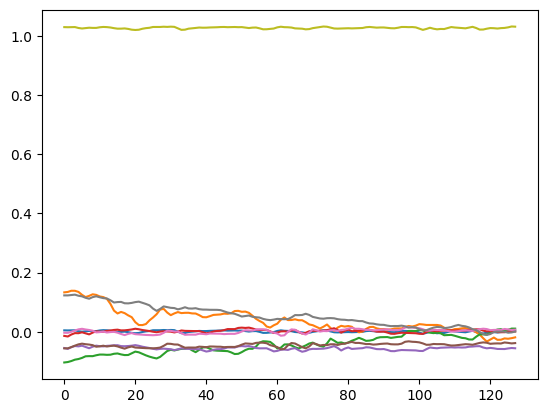

In [16]:
plt.plot(x[0]);

# **Model 🧠**

In [23]:
class RNN_model(nn.Module):
  def __init__(self, RNN, input_size, hidden_size, num_layers, bidirectional, num_classes):
    super(RNN_model, self).__init__()
    self.rnn = RNN(input_size = input_size,
                                    hidden_size = hidden_size,
                                    num_layers = num_layers,
                                    bidirectional = bidirectional)

    self.fc = nn.Linear(hidden_size, num_classes, bias= True)

  def forward(self, x):
    outputs, hn = self.rnn(x)
    y = self.fc(outputs[:, -1])
    return y

In [50]:
class CNNModel(nn.Module):
  def __init__(self, num_filters, kernel_size, num_cls):
    super(CNNModel, self).__init__()
    self.conv1 = nn.LazyConv1d(num_filters[0], kernel_size[0], padding=1)
    self.bn1 = nn.BatchNorm1d(num_filters[0])

    self.conv2 = nn.LazyConv1d(num_filters[1], kernel_size[1], padding=1)
    self.bn2 = nn.BatchNorm1d(num_filters[1])

    self.pool = nn.MaxPool1d(2, 2)
    self.fc = nn.LazyLinear(num_cls)
  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    y = self.pool(y)
    y = y.flatten(1)
    return self.fc(y)

In [54]:
class CNN_LSTM(nn.Module):
  def __init__(self, input_size, cnn_hidden_size, rnn_hidden_size, num_layers, num_cls):
    super().__init__()
    self.conv1 = nn.Conv1d(input_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn1 = nn.BatchNorm1d(cnn_hidden_size)

    self.conv2 = nn.Conv1d(cnn_hidden_size, cnn_hidden_size, kernel_size=5, padding=1)
    self.bn2 = nn.BatchNorm1d(cnn_hidden_size)

    self.pool = nn.MaxPool1d(2, 2)
    self.lstm = nn.LSTM(cnn_hidden_size, rnn_hidden_size, num_layers)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    x = x.permute(0, 2, 1)
    y = self.bn1(self.conv1(x)).relu()
    y = self.bn2(self.conv2(y)).relu()
    y = self.pool(y)
    y = y.permute(0, 2, 1)
    y, _ = self.lstm(y)
    y = self.fc(y)
    return y.mean(dim=1)

In [55]:
x, y = next(iter(train_loader))
model = CNN_LSTM(9, 32, 128, 3, 6)
outputs = model(x)
outputs.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([64, 6])

# **Device ⚙️**

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# **Utils 🧰**

In [28]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# **Functions** 🧮

In [57]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, num_classes, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass',
                                    num_classes=num_classes).to(device)
  with tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f'Epoch {epoch}')
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())

      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [58]:
def evaluate(model, valid_loader, loss_fn, num_classes):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass',
                                     num_classes=num_classes).to(device)
    for i, (inputs, targets) in enumerate(valid_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())

  return loss_valid.avg, acc_valid.compute()

# **Efficient way for set hyperparams 🔨**

In [59]:
'''

RNN      : RNNModel(nn.RNN, 9, 32, 1, False, 6)
LSTM     : RNNModel(nn.LSTM, 9, 32, 1, False, 6)
CNN      : CNNModel([64, 64], [3, 3], 6)
CNN-LSTM : CNN_LSTM(9, 32, 128, 3, 6)
'''
model = CNN_LSTM(9, 32, 128, 3, 6).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 35, gamma = 0.1)

## Step 1: check forward path

Calculate loss for one batch

In [60]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.7949, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [61]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, 6, epoch)

## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')
  model = CNN_LSTM(9, 32, 128, 3, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, 6, epoch)
  print()

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR

In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNN_LSTM(9, 32, 128, 3, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, 6, epoch)
    print()

## Step 5: train more epochs

In [62]:
model = CNN_LSTM(9, 32, 128, 3, 6).to(device)

In [63]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 35, gamma = 0.1)

In [64]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epoch = 200

In [ ]:
for epoch in range(num_epoch):

  model, loss_train, acc_train = train_one_epoch(epoch=epoch, loss_fn=loss_fn, model=model, optimizer=optimizer, train_loader=train_loader, num_classes=6)
  loss_valid, acc_valid = evaluate(model, test_loader, loss_fn, num_classes=6)

  epoch_counter += 1

  scheduler.step()

  # Update optimizer's learning rate
  lr = optimizer.param_groups[0]['lr']

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid.item())

  if loss_valid < best_loss_valid:
    best_loss_valid = loss_valid
    print('better loss detected')
    epoch_counter = 0

  print(f"valid: loss:{loss_valid:0.4f}, acc:{acc_valid:0.4f} - Learning rate: {lr}")
  print()

  if epoch_counter >= 20 :
    print('No Better results recieved')
    break

# **Plot**

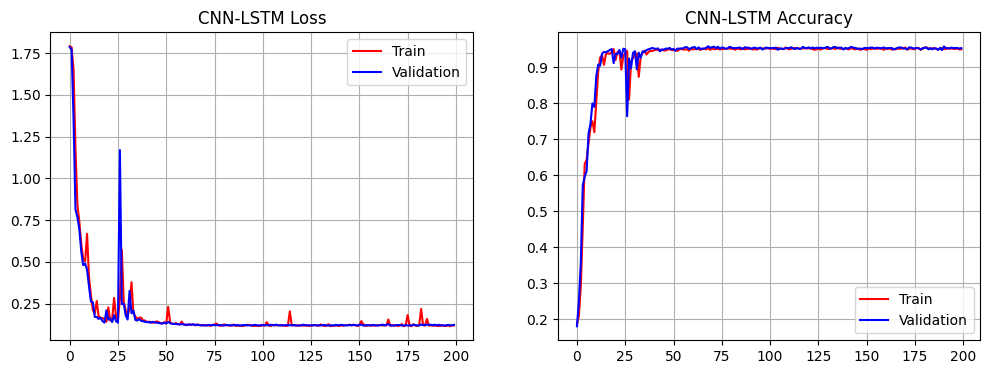

In [66]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(12, 4))


ax[0].plot(loss_train_hist, 'r-', label='Train')
ax[0].plot(loss_valid_hist, 'b-', label='Validation')
ax[0].set_title('CNN-LSTM Loss')
ax[0].grid(True)
ax[0].legend()


ax[1].plot(acc_train_hist, 'r-', label='Train')
ax[1].plot(acc_valid_hist, 'b-', label='Validation')
ax[1].set_title('CNN-LSTM Accuracy')
ax[1].grid(True)
ax[1].legend()